# Feature filter procedures are compared and model performance evaluated

In [1]:
# imports

# Models
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier as lgbm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# preprocessors
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, quantile_transform
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectFromModel, RFE
from sklearn.impute import SimpleImputer

# Samplers
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

# metrics and splitters
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# utils
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import matplotlib_venn as venn

# progress bar
from ipywidgets import IntProgress
from IPython.display import display

sys.path.append("../")

import utils_ML as uml
import AtlasAnalysisFunctions as AAF

## 3 filter procedures can be performed
1. No filtering
2. Biological filtering (x% protein occurence in a class)
3. Computational filtering through feature selection methods

Note that this can be both done on the raw protein features and after feature reduction through KEGG mapping

In [2]:
data = pd.read_csv("../PEMatrix/norm_NSAF_data2.csv", index_col = "assay_id")
meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data.sort_index(inplace=True)
meta.sort_index(inplace=True)

Set class weights

In [14]:
target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

{2: 2.6564102564102563, 9: 0.7194444444444444, 11: 1.3282051282051281, 3: 2.3022222222222224, 1: 0.3453333333333333, 7: 3.453333333333333, 5: 1.4388888888888889, 0: 0.4427350427350427, 8: 1.5014492753623188, 12: 1.4388888888888889, 10: 1.3282051282051281, 6: 0.5755555555555556, 13: 1.817543859649123, 14: 3.453333333333333, 4: 0.8222222222222222}


In [38]:
meta.cell_line.unique()

array(['Hep3B', 'MHCC97', 'LAN5', 'A431', 'HEK293', 'MCF7', 'ZR751',
       'JVM13', 'HUVEC', 'SKBR3', 'HCT116', 'K562', 'U87', 'HepG2',
       'KO52', 'Jurkat', 'SHSY5Y', 'MDA-MB-231', 'SKNBE2', 'A2780',
       'HT29', 'THP1', 'HeLa', 'iPSC', '/', 'SKOV3IP1', 'TOV112D',
       'TYKNU', 'IGROV1', 'CRC', 'MDA-MB-453', 'MDA-MB-468', 'HCC1806',
       'DU4475', 'HCC1143', 'MFM223', 'Colo-205', 'SKOV3', 'CCRF-CEM',
       'KM12', 'KURAMOCHI', 'SNU119', 'PEO1', 'PEO4', 'TYKNUCP', '59M',
       'CAOV3', 'COV318', 'HEY', 'JHOS2', 'JHOS4', 'OVCAR3', 'OVCAR5',
       'OVKATE', 'OVSAHO', 'HCC1937', 'HCC1599', 'SW527', 'HS578T',
       'BT20', 'MDA-MB-157', 'BT549', 'HCC38', 'MDA-MB-436'], dtype=object)

Initialize models

Only classes are selected with >9 entries

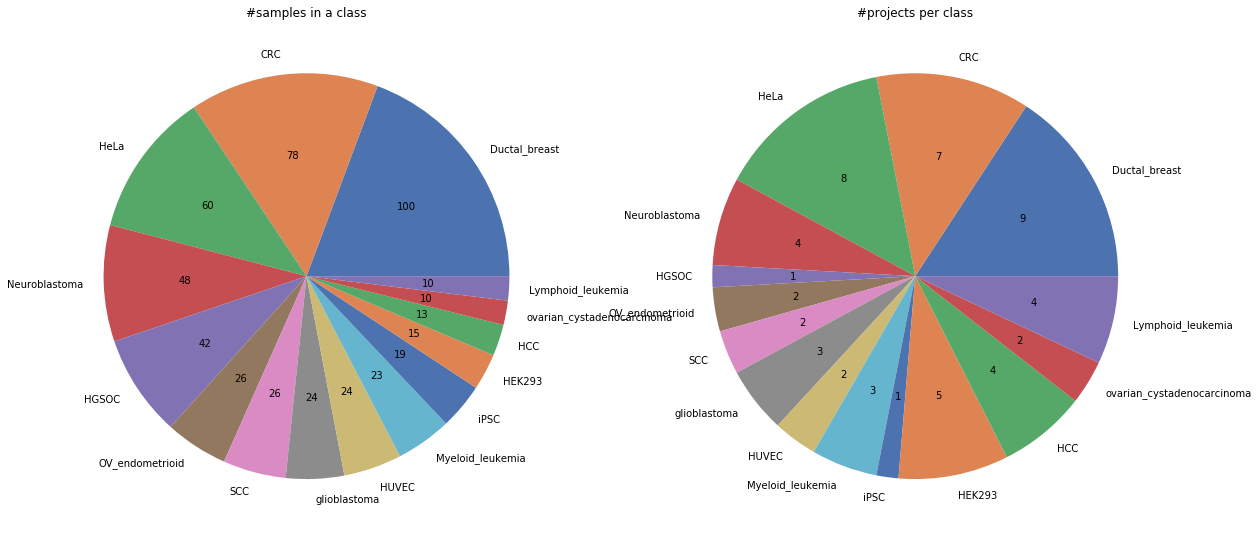

In [6]:
apc = meta.Group.value_counts(sort = True)
label_order = apc.index
ppc = meta.groupby("Group", sort = False).nunique().PXD_accession[label_order]

fig = plt.figure(figsize=(20,10))
fig.set_facecolor("white")

plt.subplot(121)
plt.title("#samples in a class")
_ = plt.pie(apc.values, labels = label_order.values, colors = sns.color_palette("deep"),
autopct= lambda p: '{:.0f}'.format(p*sum(apc.values)/100))

plt.subplot(122)
plt.title(r"#projects per class")
_ = plt.pie(ppc.values, labels = label_order.values, colors = sns.color_palette("deep"),
autopct = lambda p: '{:.0f}'.format(p*sum(ppc.values)/100))

---

# Imputation methods
- KNNimputer
- RF imputer
- Lowest value imputation (logical as missing values are unidentified proteins and thus probably below identification threshold)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


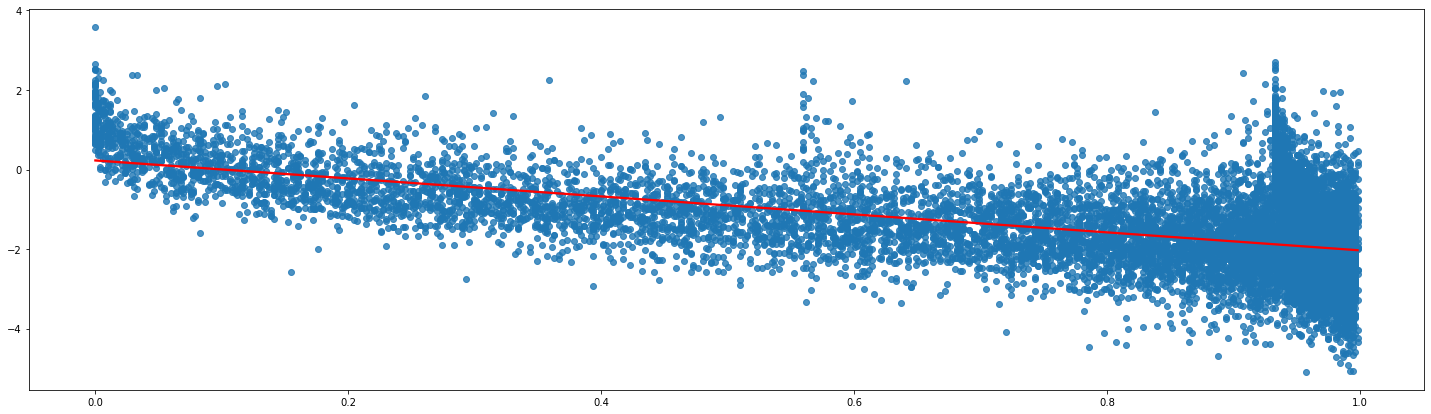

In [9]:
# Median expression value drops for proteins with lower identification rates
fig, ax = plt.subplots(1,1, figsize=(25,7))

ax.set_xlabel("Missing values")
ax.set_ylabel("Median log(expression)")

sns.regplot(x=data.isna().sum()/518, y=data.median(), line_kws={"color": "red"}, ax=ax)


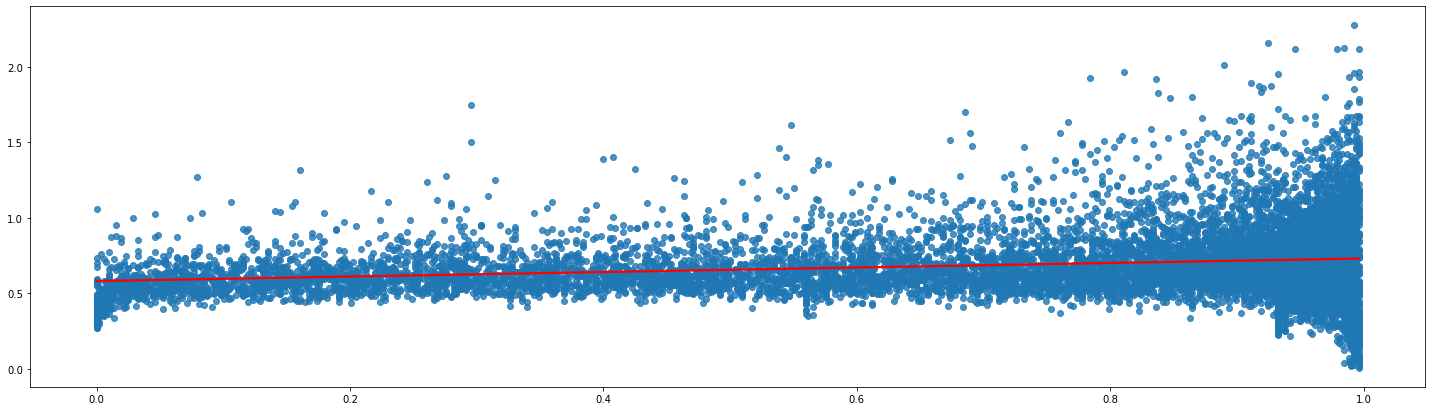

In [64]:
# Median expression value drops for proteins with lower identification rates
fig, ax = plt.subplots(1,1, figsize=(25,7))

ax.set_xlabel("Missing values")
ax.set_ylabel("Median log(expression)")

sns.regplot(x=data.isna().sum()/518, y=data.std(), line_kws={"color": "red"}, ax=ax)


NOTE: evaluate them

---

In [5]:
# Models to be used:

# The models

lgbm_clf = lgbm()
xgb_clf = XGBClassifier()
svc_clf = SVC()
rf_clf = RandomForestClassifier()
lr_clf = LogisticRegression(max_iter= 10000)
gnb_clf = GaussianNB()

models = [lgbm_clf, xgb_clf, svc_clf, rf_clf, lr_clf, gnb_clf]

# Parameter grids

lr_grid = {"penalty" : ['l2', 'l1'],
            "dual": [False],
            "max_iter": [10000],
            "class_weight": [weights],
            "C": np.linspace(0.005, 15, 10),
            'solver': ['newton-cg', 'sag', 'lbfgs', "liblinear"]}

svc_grid = {'decision_function_shape': ["ovr"],
            "kernel": ['linear', 'poly', 'rbf'],
            "C": np.linspace(0.0005, 5, 10),
            "class_weight": [weights]}

rf_grid = {'n_estimators': np.linspace(10, 200, 4, dtype = int),
            "criterion": ["entropy", "gini"], 
            "max_depth": [10,20,40, None],
            "class_weight": [weights]}

gnb_grid = {'var_smoothing': np.logspace(0,-15,15)}

xgb_grid = {"verbosity": [0],
            'eta': np.linspace(0.005,0.5,5),
            'gamma': np.linspace(0.005,10,5),
            'max_depth': [3,5,7,10]}

grids = {"lr": lr_grid, "svc": svc_grid, "rf": rf_grid, "gnb": gnb_grid}

In [5]:
# based on: https://towardsdatascience.com/coding-a-custom-imputer-in-scikit-learn-31bd68e541de

class LowestValueImputer(BaseEstimator, TransformerMixin):
    '''
    Imputes the lowest value in that column
    '''

    def __init__(self):
        self.fitted = False

    def fit(self, X, y = None):
        self.impute_map = X.min()

        # If protein columns has all nans, impute the lowest value in the dataframe
        self.impute_map = self.impute_map.fillna(self.impute_map.min())
        return self

    def transform(self, X, y=None):
        check_is_fitted(self, 'impute_map')
        
        X = X.copy()

        for index, row in self.impute_map.iteritems():
            ind = X.index[X.loc[:,index].isna()]
            X.loc[ind, index] = X.loc[ind, index].fillna(self.impute_map[index])
        
        return X

In [6]:
def scoring_functions(Y_pred, Y_test, labels):
    """Returns pxd_f1, micro_f1, macro_f1, cm"""
        
    micro_f1 = f1_score(Y_test, Y_pred, labels=labels, average = "micro")
    macro_f1 = f1_score(Y_test, Y_pred, labels=labels, average = "macro")
    weighted_f1 = f1_score(Y_test, Y_pred, labels=labels, average = "weighted")
    cm = confusion_matrix(Y_test, Y_pred, labels=labels)
    
    return micro_f1, macro_f1, weighted_f1, cm

In [7]:
def save_results(df: pd.DataFrame, name_file: str):
    """Writes results away to a file"""
    try:
        file = pd.read_csv(f"results/{name_file}.csv", sep = ";")
        df = pd.concat([file, df], ignore_index = True)
        df.to_csv(f"results/{name_file}.csv", sep = ";", index=False)
    except:
        df.to_csv(f"results/{name_file}.csv", sep = ";", index=False)

# 1. No filtering

Only use proteins that are present in x% of the dataset

Evaluate what the effect is of this type of filtering on the performance of the model. Oversample with SMOTETomek

In [8]:
class FilterByOccurence(BaseEstimator, TransformerMixin):
    '''
    Filters the proteins that occur in 50% of the training samples
    '''
    def __init__(self, percentage=.5):
        self.percentage = percentage

    def fit(self, X: pd.DataFrame, y = None):
        proteins, _ = AAF._identify_global_reoccured_proteins(X.fillna(0), self.percentage)
        
        self.filtered_proteins = proteins
        self.n_features = len(proteins)

        return self

    def transform(self, X: pd.DataFrame, y=None):
        check_is_fitted(self, 'filtered_proteins')

        return X.loc[:, self.filtered_proteins]

In [10]:
proteins, deleted = AAF._identify_global_reoccured_proteins(data.fillna(0), percentage_reoccurence=.5)
data.loc[:,proteins].shape

(518, 2615)

In [6]:
f = IntProgress(min=0, max= 5 * 6) # splits * preprocessors * oversampling methods * models
display(f)

models = [lr_clf, svc_clf, rf_clf]
skf = StratifiedKFold(n_splits=5, shuffle=True)

fold = 0
for train, test in skf.split(X = data, y = targets):
    
    fold += 1
    # Split data
    X_train = data.iloc[train,:]
    Y_train = targets[train]
    X_test = data.iloc[test,:]
    Y_test = targets[test]

    # Filter impute and scale the data
    # Try [.2, .4, .5, .6, .75, .9] filtering
    for filter_percentage in [.2, .4, .5, .6, .75, .9]:
        filtering = uml.FilterByOccurence(percentage=filter_percentage)
        imputer = uml.LowestValueImputer()
        scaler = MinMaxScaler()

        preprocessor = Pipeline(steps=[
            ('filtering', filtering),
            ('imputer', imputer),
            ('scaler', scaler)
        ])

        # Preprocess the data
        preprocessor.fit(X_train)
        X_train_preprocessed = preprocessor.transform(X_train)
        X_test_preprocessed = preprocessor.transform(X_test)

        X_oversampled, Y_oversampled = SMOTETomek().fit_resample(X_train_preprocessed, Y_train)

        for model in models:
            
            model.fit(X_oversampled, Y_oversampled)
            Y_pred = model.predict(X_test_preprocessed)

            micro_f1, macro_f1, weighted_f1, cm = uml.scoring_functions(Y_pred=Y_pred, Y_test=Y_test, labels=unique_labels)
            
            results_df = pd.DataFrame({"model": [type(model).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                        "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm], "filter_type": ["global"],
                                        "filter_percentage": [filter_percentage], "proteins": [len(preprocessor.named_steps.filtering.filtered_proteins)]})
            
            uml.save_results(results_df, "global_filtering_skf")

            f.value += 1

IntProgress(value=0, max=30)

In [62]:
data_50 = data.loc[:,proteins]

In [65]:
models = [lgbm_clf, svc_clf, rf_clf, lr_clf]
skf = StratifiedKFold(n_splits=10, shuffle=True)

fold = 0
for train, test in skf.split(X = data_50, y = targets):
    fold += 1
    print(fold)

    # Split data
    X_train = data.iloc[train,:]
    Y_train = targets[train]
    X_test = data.iloc[test,:]
    Y_test = targets[test]

    # Impute and scale the data
    imputer = LowestValueImputer()
    scaler = MinMaxScaler()

    preprocessor = Pipeline(steps=[
        ("imputer", imputer),
        ("scaler", scaler)
    ])

    preprocessor.fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)

    # Iterate over each model
    for model in models:
        
        model.set_params(**{'class_weight': weights})

        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)

        # Evaluate performance
        micro_f1, macro_f1, weighted_f1, cm = scoring_functions(Y_pred=Y_pred, Y_test=Y_test, labels=unique_labels)
        
        # Store performance metrics
        # TODO: add calibration curves for models returning class probability

        results_df = pd.DataFrame({"model": [type(model).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                    "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm]})
        
        save_results(results_df, "nf_50_LVI")

1
2
3
4
5
6
7
8
9
10


Make pipeline

In [64]:
global_filter_pipeline = Pipeline(steps=[
    ('filter', FilterByOccurence()),
    ('imputer', LowestValueImputer()),
    ('scaler', MinMaxScaler())
])

# 2. Biological filtering

A problem with only modelling with 50% of co-occuring proteins is that the very cell line specific proteins are filtered out as they most likely will only be present in the representative classes. A solution would be to filter protein on classes separatly.

There are 2 possible strategies: 
1. Use the 50% filtering of each class to select the proteins to be represented during fitting.
2. Also delete the proteins specific to a class that are not within the 50% samples of that class.

In [9]:
class FilterByClass(BaseEstimator, TransformerMixin):
    '''
    Filters the proteins by class that occur in 50% of the training samples

    keep: bool (keep the proteins of a sample in a class that that do not occur in 50% of the samples in that class yet do in other classes)
    '''

    def __init__(self, keep=False, percentage=0.5):
        self.keep = keep
        self.filter_per_class = {}
        self.percentage = percentage

    def fit(self, X: pd.DataFrame, y = False):
        assert y.any()

        reoccuring_proteins = []

        # Make subsets
        for cls in pd.Series(y).unique():
            ind = np.where(y == cls)[0]
            subset = X.reset_index(drop=True).loc[ind,:]

            proteins, deleted = AAF._identify_global_reoccured_proteins(subset=subset.fillna(0), percentage_reoccurence=self.percentage)
            reoccuring_proteins += proteins
            
            self.filter_per_class[cls] = proteins

        self.filtered_proteins = set(reoccuring_proteins)

        return self

    def transform(self, X: pd.DataFrame, y=False):
        check_is_fitted(self, 'filtered_proteins')

        if self.keep:
            return X.loc[:, self.filtered_proteins]

        # Data leakage is necessary to execute this function. The effect of leakage is evaluated by shuffling the labels
        assert y.any()
        # Make the abundance values np.nan that do not occur > percentage in samples of a class
        X = X.copy()
        X = X.reset_index(drop=True)

        for cls in pd.Series(y).unique():
            ind_row = np.where(y == cls)[0]
            X.loc[ind_row, ~X.columns.isin(self.filter_per_class[cls])] = np.nan

        return X.loc[:, self.filtered_proteins]

In [10]:
filtering = uml.FilterByClass(keep=False, percentage=.9)
filtering.fit(data,targets)

FilterByClass(percentage=0.9)

Evaluate the selection of the co-occuring proteins for each class

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7f7810061310>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7f781050cf90>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7f780f92a490>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7f780d6c6dd0>}

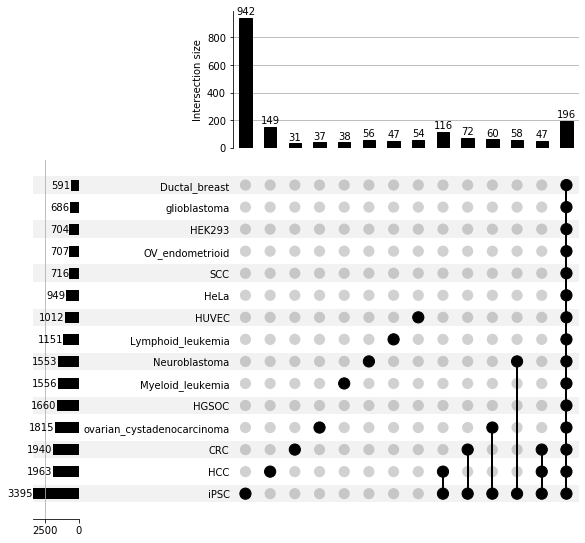

In [11]:
import upsetplot as uplt

# After filtering 70% co-occuring proteins per class
upset_proteins = {}
for cls, prots in filtering.filter_per_class.items():
    upset_proteins[target_encoder.inverse_transform([cls])[0]] = set(prots)

contents = uplt.from_contents(upset_proteins)
uplt.plot(contents, show_counts = True, min_subset_size = 30)

<BarContainer object of 15 artists>

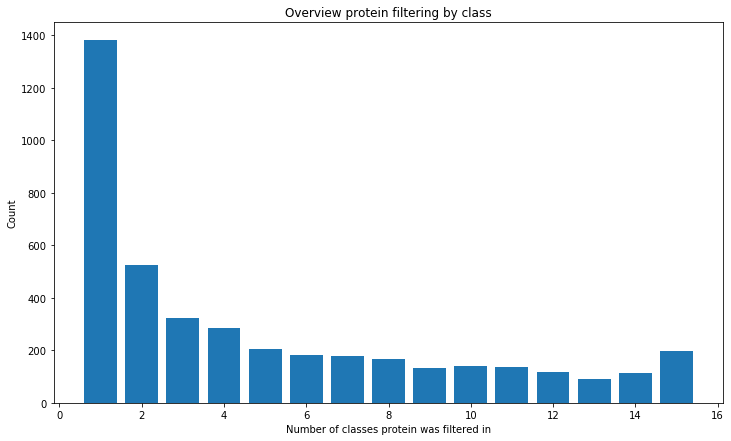

In [12]:
total_prots = []
for prots in upset_proteins.values():
    total_prots += list(prots)

count_prot = {}
for prot in set(total_prots):
    repeats = total_prots.count(prot)
    if repeats not in count_prot.keys():
        count_prot[repeats] = 1
    else:
        count_prot[repeats] += 1
    
plt.figure(figsize=(12,7))
plt.title("Overview protein filtering by class")
plt.ylabel("Count")
plt.xlabel("Number of classes protein was filtered in")
plt.bar(x=count_prot.keys(), height=count_prot.values())

Most filtered proteins seem to be pretty specific for a class. However, this might be biased by a class being represented by more in depth proteome profiles

In [16]:
models = [lgbm_clf, svc_clf, rf_clf, lr_clf]
skf = StratifiedKFold(n_splits=10, shuffle=True)

fold = 0
for train, test in skf.split(X = data, y = targets):
    fold += 1
    print(fold)

    # Split data
    X_train = data.iloc[train,:]
    Y_train = targets[train]
    X_test = data.iloc[test,:]
    Y_test = targets[test]

    # We need a shuffled dataframe to see what the bias is of the filter function (it deletes proteins based on the class)
    X_train_shuffled = X_train.sample(frac=1, random_state=1)

    # Filter (not in pipeline due to y-related errors)
    filtering = FilterByClass(keep=True, percentage=.7) # Ran with and without keeping the filtered proteins
    filtering.fit(X_train, Y_train)
    X_train = filtering.transform(X_train, Y_train)
    X_test_ = filtering.transform(X_test, Y_test)

    filtering_shuffle = FilterByClass(keep=True, percentage=.7)
    filtering_shuffle.fit(X_train_shuffled, Y_train)
    X_train_shuffled = filtering_shuffle.transform(X_train_shuffled, Y_train)
    X_test_shuffled = filtering_shuffle.transform(X_test, Y_test)

    # impute and scale the data
    imputer = LowestValueImputer()
    scaler = MinMaxScaler()

    preprocessor = Pipeline(steps=[
        ("imputer", imputer),
        ("scaler", scaler)
    ])

    preprocessor.fit(X_train, Y_train)
    X_train = preprocessor.transform(X_train)
    X_test_ = preprocessor.transform(X_test_)

    preprocessor.fit(X_train_shuffled, Y_train)
    X_train_shuffled = preprocessor.transform(X_train_shuffled)
    X_test_shuffled = preprocessor.transform(X_test_shuffled)

    # Iterate over each model
    for model in models:
        
        model.set_params(**{'class_weight': weights})

        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test_)

        # Evaluate performance
        micro_f1, macro_f1, weighted_f1, cm = scoring_functions(Y_pred=Y_pred, Y_test=Y_test, labels=unique_labels)
        
        # Store performance metrics
        # TODO: add calibration curves for models returning class probability

        results_df = pd.DataFrame({"Mode": ["True"], "model": [type(model).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                    "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm]})
        
        save_results(results_df, "bf_70_keep_LVI")

        '--------------------------------------'

        # Shuffled control
        model.fit(X_train_shuffled, Y_train)
        Y_pred_shuffled = model.predict(X_test_shuffled)

        # Evaluate performance
        micro_f1, macro_f1, weighted_f1, cm = scoring_functions(Y_pred=Y_pred_shuffled, Y_test=Y_test, labels=unique_labels)
        
        # Store performance metrics
        # TODO: add calibration curves for models returning class probability

        results_df = pd.DataFrame({"Mode": ["Shuffled"], "model": [type(model).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                    "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm]})
        
        save_results(results_df, "bf_70_keep_LVI")

1
2
3
4
5
6
7
8
9
10


make pipeline

In [55]:
biological_pipeline = Pipeline(steps=[
    ('filter', FilterByClass(keep=True)),
    ('imputer', LowestValueImputer()),
    ('scaler', MinMaxScaler())
])

# 3. Computational filtering

A problem with biological filtering is that you introduce class-specific biases. This could be solved by utilizing other filtering techniques that do not look at class-specific characteristics, yet do aim to optimize model performance. <br> These techniques include the feature selection methods as described in 'KEGG_mapping.ipynb' <br>
Besides the filtering methods discussed above, another dimensionality technique is possible: feature reduction by grouping proteins in pathway features represented by KEGG

For a similar analysis on pathway level, see ML_model_pathway.ipynb

In [10]:
# Feature importance selection --> ensemble

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selectors = ['anova', 'MI', 'LR'], num_features = 2000, threshold = 0.5):
        """
        Kind: Which feature selector to use? one/multiple of the following:
            - anova
            - chi2
            - MI
            - LR
            - SVC
            - all
        """

        self.selectors = selectors
        self.num_features = num_features
        self.threshold = threshold
        

    def fit(self, X, y):
    
        self.selector_models = []

        for selector in self.selectors:
            if selector == "anova":
                self.selector_models.append(SelectKBest(f_classif, k = self.num_features))
            if selector == "chi2":
                self.selector_models.append(SelectKBest(chi2, k = self.num_features))
            if selector == "MI":
                self.selector_models.append(SelectKBest(mutual_info_classif, k = self.num_features))
            if selector == "LR":
                self.selector_models.append(SelectFromModel(LogisticRegression(penalty="l1", solver = "liblinear", multi_class="ovr"), max_features=self.num_features))
            if selector == "SVC":
                self.selector_models.append(RFE(SVC(class_weight="balanced", kernel = "linear"), n_features_to_select=self.num_features, step=500))

        self.supports = []
        
        for selector in self.selector_models:
            selector.fit(X,y)
            self.supports.append(selector.get_support())
        
        votes = np.sum(self.supports, axis = 0) / len(self.selector_models)
        final_mask = votes >= self.threshold
        self.final_mask = final_mask

        print(f"Selected {sum(final_mask)} features.")

        return self


    def transform(self, X, y = None):
        return pd.DataFrame(X).loc[:,self.final_mask]

## Univariate statistics feature selection

In [11]:
# TODO: implement this in the feature selector
def quantilize_df(df, nan_format):
    # Assumptions chi square: The df in the cells should be frequencies, or counts of cases rather than percentages or some other transformation of the df.
    # Therefor, the expression values are discritized in the following manner: 
    #       - for proteins with <= 20 identifications: Use binary 0 or 1 for identification
    #       - for proteins with > 20 identifications: create 5 subgroups:
    #            - null values --> 0; first quantile --> 1, second quantile --> 2, third quantile --> 3, fourth quantile --> 4

    boolean_proteins = []
    if nan_format == "nan":
        boolean_proteins = df.columns[df.notna().sum() <= 20]
    elif nan_format == "0":
        boolean_proteins = df.columns[(df == 0).sum() <= 20]

    quantile_proteins = df.columns[~df.columns.isin(boolean_proteins)]

    new_df = []
    for uniprot_id, column in df.iteritems():
        if uniprot_id in boolean_proteins:
            new_df.append(column.notna().astype(int))

        else:
            q1, q2, q3 = [np.nanquantile(column,q) for q in [.25, .5, .75]]

            mask = column.notna()
            new_column = column.fillna(0)

            mask = column < q1
            new_column = pd.Series(np.where(mask, 1, new_column), index=new_column.index)

            mask = (column < q2) & (column >= q1)
            new_column = pd.Series(np.where(mask, 2, new_column), index=new_column.index)

            mask = (column < q3) & (column >= q2)
            new_column = pd.Series(np.where(mask, 3, new_column), index=new_column.index)

            mask = column >= q3
            new_column = pd.Series(np.where(mask, 4, new_column), index=new_column.index)

            new_df.append(new_column.rename(uniprot_id))

    return pd.concat(new_df, axis=1).astype(int)

In [ ]:
quantilized_data = quantilize_df(data, 'nan')

In [22]:
# impute and scale the data
imputer = LowestValueImputer()
scaler = MinMaxScaler()

preprocessor = Pipeline(steps=[
    ("imputer", imputer),
    ("scaler", scaler)
])

processed_data = preprocessor.fit_transform(data)
processed_data = pd.DataFrame(processed_data, index=data.index, columns=data.columns)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [12224] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  118   431  1584  2298  2555  3333  3337  3372  3451  3663  4239  4294
  6003  6757  7050  7185  7469  8109  8160  9000  9245 10322 12224 12320
 13470 13543 13916] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid v

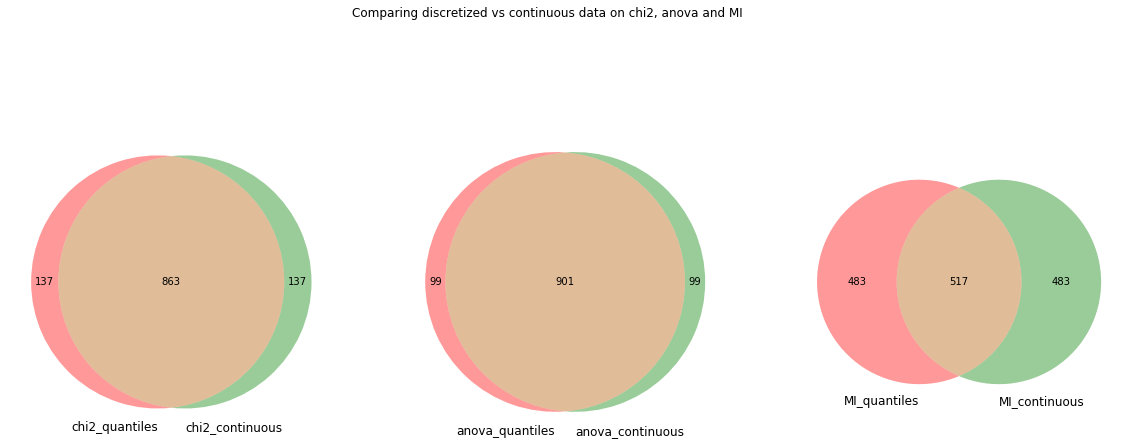

In [13]:
fig, ax = plt.subplots(1,3, figsize= (20,8), facecolor = "white")

fig.suptitle("Comparing discretized vs continuous data on chi2, anova and MI")

chi2_features_q = SelectKBest(chi2, k = 1000).fit(quantilized_data, targets)
chi2_q = pd.Series(chi2_features_q.scores_, index = processed_data.columns).reset_index(name = "f_value").rename(columns = {"index":"path_id"}).sort_values(by = "f_value", ascending = False).reset_index()
chi2_q = set(chi2_q.iloc[:1000,1])

chi2_features_nq = SelectKBest(chi2, k = 1000).fit(processed_data, targets)
chi2_nq = pd.Series(chi2_features_nq.scores_, index = processed_data.columns).reset_index(name = "f_value").rename(columns = {"index":"path_id"}).sort_values(by = "f_value", ascending = False).reset_index()
chi2_nq = set(chi2_nq.iloc[:1000,1])

venn.venn2([chi2_q, chi2_nq], ("chi2_quantiles", "chi2_continuous"), ax = ax[0])

f_classif_features_q = SelectKBest(f_classif, k = 1000).fit(quantilized_data, targets)
f_features_q = pd.Series(f_classif_features_q.scores_, index = processed_data.columns).reset_index(name = "f_value").rename(columns = {"index":"path_id"}).sort_values(by = "f_value", ascending = False).reset_index()
anova_set_q = set(f_features_q.iloc[:1000,1])

f_classif_features_nq = SelectKBest(f_classif, k = 1000).fit(processed_data, targets)
f_features_nq = pd.Series(f_classif_features_nq.scores_, index = processed_data.columns).reset_index(name = "f_value").rename(columns = {"index":"path_id"}).sort_values(by = "f_value", ascending = False).reset_index()
anova_set_nq = set(f_features_nq.iloc[:1000,1])

venn.venn2([anova_set_q, anova_set_nq], ("anova_quantiles", "anova_continuous"), ax = ax[1])

mutual_info_classif_features_q = SelectKBest(mutual_info_classif, k = 1000).fit(quantilized_data, targets)
MI_q = pd.Series(mutual_info_classif_features_q.scores_, index = processed_data.columns).reset_index(name = "f_value").rename(columns = {"index":"path_id"}).sort_values(by = "f_value", ascending = False).reset_index()
MI_q = set(MI_q.iloc[:1000,1])

mutual_info_classif_features_nq = SelectKBest(mutual_info_classif, k = 1000).fit(processed_data, targets)
MI_nq = pd.Series(mutual_info_classif_features_nq.scores_, index = processed_data.columns).reset_index(name = "f_value").rename(columns = {"index":"path_id"}).sort_values(by = "f_value", ascending = False).reset_index()
MI_nq = set(MI_nq.iloc[:1000,1])

venn.venn2([MI_q, MI_nq], ("MI_quantiles", "MI_continuous"), ax = ax[2])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [12224] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


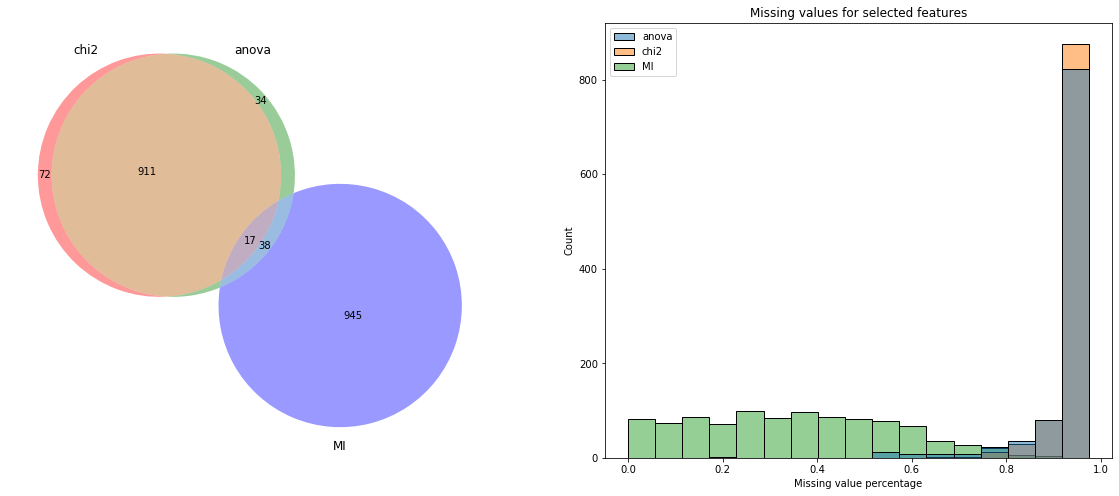

In [14]:
chi2_features = SelectKBest(chi2, k = 1000).fit(quantilized_data, targets)
f_classif_features = SelectKBest(f_classif, k = 1000).fit(quantilized_data, targets)
mi_features = SelectKBest(mutual_info_classif, k = 1000).fit(processed_data, targets)

# Parsing
MI_f = pd.Series(mi_features.scores_, index = processed_data.columns).reset_index(name = "MI").rename(columns = {"index":"path_id"}).sort_values(by = "MI", ascending = False).reset_index()
f_features = pd.Series(f_classif_features.scores_, index = processed_data.columns).reset_index(name = "f_value").rename(columns = {"index":"path_id"}).sort_values(by = "f_value", ascending = False).reset_index()
chi2_scores = pd.Series(chi2_features.scores_, index = processed_data.columns).reset_index(name = "chi2_scores").rename(columns = {"index":"path_id"}).sort_values(by = "chi2_scores", ascending = False).reset_index()

chi2_set = set(chi2_scores.iloc[:1000,1])
anova_set = set(f_features.iloc[:1000,1])
MI_set = set(MI_f.iloc[:1000,1])

# "--------------------------------"

missing_percentage = pd.concat([data.loc[:, anova_set].isna().sum().reset_index(drop=True) / 518, data.loc[:, chi2_set].isna().sum().reset_index(drop=True) / 518, data.loc[:, MI_set].isna().sum().reset_index(drop=True) / 518], 
          axis=1, ignore_index=True)

fig, ax = plt.subplots(1,2, figsize= (20,8), facecolor = "white")

ax[1].set_title("Missing values for selected features")
ax[1].set_xlabel("Missing value percentage")
sns.histplot(data=missing_percentage.rename(columns={0: "anova", 1: "chi2", 2: "MI"}), ax=ax[1])

venn.venn3([chi2_set, anova_set, MI_set], ("chi2", "anova", "MI"), ax=ax[0])

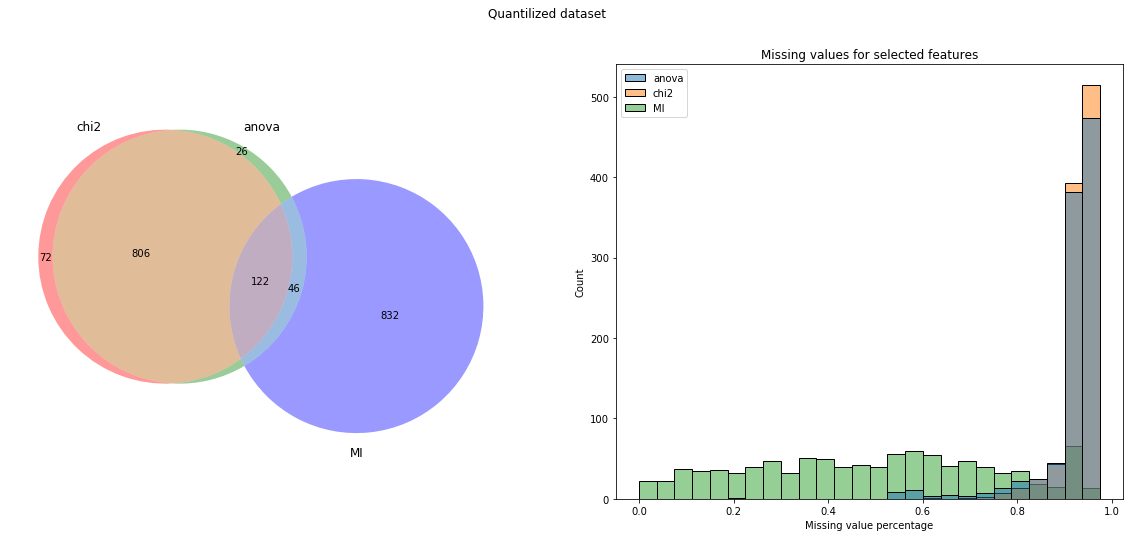

In [17]:
missing_percentage = pd.concat([data.loc[:, anova_set].isna().sum().reset_index(drop=True) / 518, data.loc[:, chi2_set].isna().sum().reset_index(drop=True) / 518, data.loc[:, MI_q].isna().sum().reset_index(drop=True) / 518], 
          axis=1, ignore_index=True)

fig, ax = plt.subplots(1,2, figsize= (20,8), facecolor = "white")

fig.suptitle("Quantilized dataset")

ax[1].set_title("Missing values for selected features")
ax[1].set_xlabel("Missing value percentage")
sns.histplot(data=missing_percentage.rename(columns={0: "anova", 1: "chi2", 2: "MI"}), ax=ax[1])

venn.venn3([chi2_set, anova_set, MI_q], ("chi2", "anova", "MI"), ax=ax[0])

CHI2 and anova tend to pick features that are very sparsely represented.

## Model-based feature selection

In [50]:
estimator_svc = SVC(kernel="linear", class_weight=weights)
selector_svc = RFE(estimator_svc, n_features_to_select=1000, step=500)
selector_svc = selector_svc.fit(processed_data, y)

print("Fitted SVC")

selector_lr = RFE(LogisticRegression(penalty="l1", solver = "liblinear", multi_class="ovr", class_weight=weights), n_features_to_select=1000, step=500)
selector_lr = selector_lr.fit(processed_data, y)

print("Fitted LR")

lr_f = pd.Series(selector_lr.get_support(), index = processed_data.columns).reset_index(name = "LR").rename(columns = {"index":"path_id"})
lr_f = lr_f[lr_f.LR]
svc_f = pd.Series(selector_svc.get_support(), index = processed_data.columns).reset_index(name = "SVC").rename(columns = {"index":"path_id"})
svc_f = svc_f[svc_f.SVC]

Fitted SVC
Fitted LR


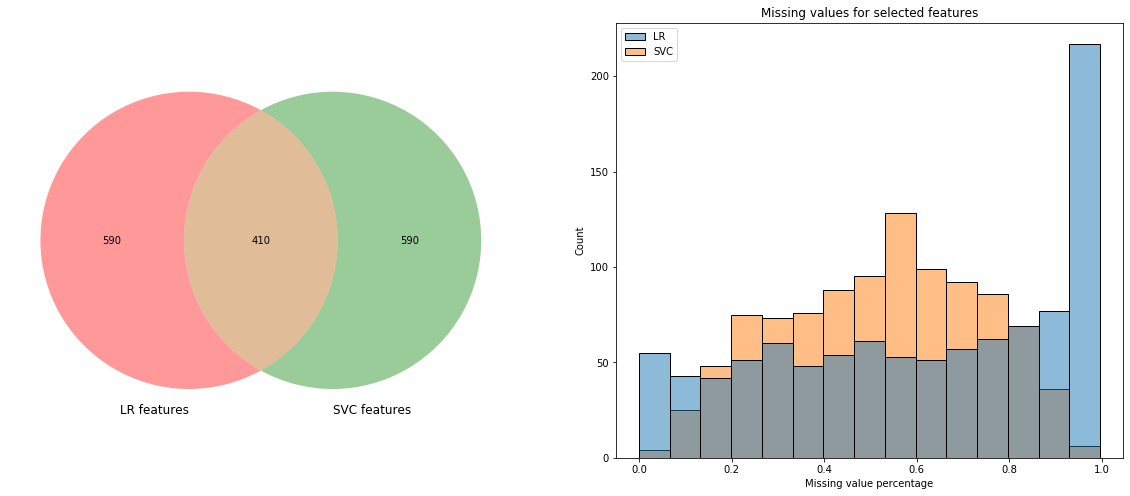

In [51]:
fig, ax = plt.subplots(1,2, figsize= (20,8), facecolor = "white")

lr_set = set(lr_f.path_id)
svc_set = set(svc_f.path_id)


venn.venn2([lr_set, svc_set], ("LR features", "SVC features"), ax=ax[0])

missing_percentage = pd.concat([data.loc[:, lr_set].isna().sum().reset_index(drop=True) / 518, data.loc[:, svc_set].isna().sum().reset_index(drop=True) / 518], 
          axis=1, ignore_index=True)

ax[1].set_title("Missing values for selected features")
ax[1].set_xlabel("Missing value percentage")
sns.histplot(data=missing_percentage.rename(columns={0: "LR", 1: "SVC"}), ax=ax[1])

Q99623
P35626
A6NKG5
P07737
P20290
Q9BQ69
Q63HM9
Q9BYV8
O14980
P19022
Q9UN70
Q15056
P52815
A0FGR8
P52292
O43390


<BarContainer object of 5 artists>

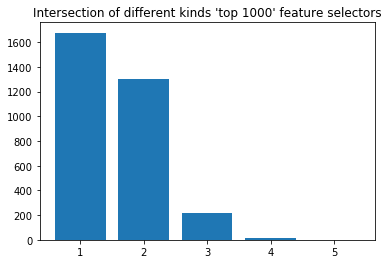

In [52]:
sets_ = [anova_set, chi2_set, MI_q, lr_set, svc_set]
intersection = {x: 0 for x in range(1,6)}

for protein in anova_set | chi2_set | MI_q | lr_set | svc_set:
    found = 0
    for set_ in sets_:
        if protein in set_:
            found += 1

    if found >= 4:
        print(protein)
    intersection[found] += 1

plt.title("Intersection of different kinds 'top 1000' feature selectors")
plt.bar(x=intersection.keys(), height=intersection.values())

Does log-transform affect feature selection?

In [13]:
preprocessor_log = Pipeline(steps=[
    ('LowestValueImputer', uml.LowestValueImputer()),
    ('scaler', MinMaxScaler()),
    ('feature_selection', uml.FeatureSelector(selectors= ['LR', "MI", 'SVC'], num_features=3000, threshold=.5))
])

exp_data = np.exp2(data)
preprocessor_ = Pipeline(steps=[
    ('filter', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', MinMaxScaler()),
    ('feature_selection', uml.FeatureSelector(selectors= ['LR', "MI", 'SVC'], num_features=3000, threshold=.5))
])

log_selection = preprocessor_log.fit_transform(data, targets)
exp_selection = preprocessor_.fit_transform(exp_data, targets)

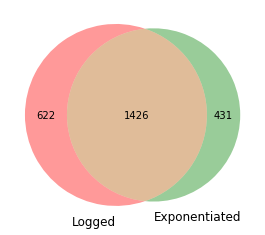

In [19]:
venn.venn2([set(log_selection.columns), set(exp_selection.columns)], ("Logged", "Exponentiated"))

How do feature selection methods compare in selecting suitable features

In [ ]:
# Select 1000 features with each feature selector on same training set and compare accuracy of the resulting model
model = LogisticRegression(max_iter=10000)

skf = StratifiedKFold(n_splits=10, shuffle=True)
fold = 0

for train, test in skf.split(X = data, y = targets):
    fold += 1
    print(fold)

    # Split data
    X_train = data.iloc[train,:]
    Y_train = targets[train]
    X_test = data.iloc[test,:]
    Y_test = targets[test]

    preprocessor = Pipeline(steps=[
    ('imputer', uml.LowestValueImputer()),
    ('scaler', MinMaxScaler())
    ])

    preprocessor.fit(X_train)
    X_train_preprocessed = preprocessor.transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)
    
    feature_selector_method = ["anova", "chi2", "MI", "LR", "SVC"]
    for fs in feature_selector_method:
        selector = uml.FeatureSelector(selectors=[fs], num_features=1000)
        
        selector.fit(X_train_preprocessed, Y_train)
        X_train_selection = selector.transform(X_train_preprocessed)
        X_test_selection = selector.transform(X_test_preprocessed)

        X_train_oversampled, Y_train_oversampled = SMOTETomek().fit_resample(X_train_selection, Y_train)

        model.fit(X_train_oversampled, Y_train_oversampled)
        Y_pred = model.predict(X_test_selection)

        micro_f1, macro_f1, weighted_f1, cm = uml.scoring_functions(Y_pred=Y_pred, Y_test=Y_test, labels=unique_labels)
        
        results_df = pd.DataFrame({"model": [type(model).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                        "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm], "selector": [fs],
                                        "oversampler": ["SMOTETomek"]})
            
        uml.save_results(results_df, "feature_selection_comparison_edit")

In results, MI, LR and SVC feature selectors performed better than anova and chi2. Try these for multiple cutoffs and see which cutoff works best

In [11]:
f = IntProgress(min=0, max= 10*5*3) 
display(f)

models = [LogisticRegression(max_iter=10000), SVC(), RandomForestClassifier()]

cutoffs = [6000, 4500, 3000, 1500, 500]

skf = StratifiedKFold(n_splits=10, shuffle=True)
fold = 0

for train, test in skf.split(X = data, y = targets):
    fold += 1
    print(fold)

    # Split data
    X_train = data.iloc[train,:]
    Y_train = targets[train]
    X_test = data.iloc[test,:]
    Y_test = targets[test]

    preprocessor = Pipeline(steps=[
    ('imputer', LowestValueImputer()),
    ('scaler', MinMaxScaler())
    ])

    preprocessor.fit(X_train)
    X_train_preprocessed = preprocessor.transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    for cutoff in cutoffs:
        selector = FeatureSelector(selectors=['MI', 'SVC', 'LR'], num_features=cutoff)

        selector.fit(X_train_preprocessed, Y_train)
        X_train_selection = selector.transform(X_train_preprocessed)
        X_test_selection = selector.transform(X_test_preprocessed)

        X_train_oversampled, Y_train_oversampled = SMOTETomek().fit_resample(X_train_selection, Y_train)

        for model in models:

            model.fit(X_train_oversampled, Y_train_oversampled)
            Y_pred = model.predict(X_test_selection)

            micro_f1, macro_f1, weighted_f1, cm = scoring_functions(Y_pred=Y_pred, Y_test=Y_test, labels=unique_labels)
            
            results_df = pd.DataFrame({"model": [type(model).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                            "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm], "cutoff": [cutoff],
                                            "oversampler": ["SMOTETomek"]})
                
            save_results(results_df, "feature_selection_cutoff")

            f.value += 1

IntProgress(value=0, max=150)

1
Selected 4723 features.
Selected 3373 features.
Selected 2015 features.
Selected 922 features.
Selected 277 features.
2
Selected 4665 features.
Selected 3317 features.
Selected 1992 features.
Selected 965 features.
Selected 261 features.
3
Selected 4760 features.
Selected 3387 features.
Selected 2029 features.
Selected 981 features.
Selected 275 features.
4
Selected 4773 features.
Selected 3353 features.
Selected 2020 features.
Selected 954 features.
Selected 270 features.
5
Selected 4721 features.
Selected 3297 features.
Selected 1961 features.
Selected 953 features.
Selected 258 features.
6
Selected 4727 features.
Selected 3335 features.
Selected 2005 features.
Selected 928 features.
Selected 274 features.
7
Selected 4700 features.
Selected 3303 features.
Selected 2015 features.
Selected 954 features.
Selected 258 features.
8
Selected 4687 features.
Selected 3305 features.
Selected 2012 features.
Selected 969 features.
Selected 268 features.
9
Selected 4714 features.
Selected 3345 

KeyboardInterrupt: 

The computational-based feature selection methods tend to pick very different proteins than filtering based on occurence. The less prevalent features are preferred.

## Train models on the different feature selection methods

In [53]:
def train_model(model, X, y, X_test):
    model.fit(X, y)
    Y_pred = model.predict(X_test)
    return Y_pred

def Oversample(X,y):
    X_SMOTE, y_SMOTE = SMOTE().fit_resample(X, y)
    X_SMOTEENN, y_SMOTEENN = SMOTEENN().fit_resample(X, y)
    X_tomek, y_tomek = SMOTETomek().fit_resample(X, y)

    return {"SMOTE": [X_SMOTE, y_SMOTE], "SMOTEENN": [X_SMOTEENN, y_SMOTEENN], "SMOTETomek": [X_tomek, y_tomek]}

In [45]:
# Only train a LR and RF to compare feature selection methods

models = [SVC(), RandomForestClassifier()]
skf = StratifiedKFold(n_splits=10, shuffle=True)

global_filter = [.25, .5, .7, .9]
biological_filter = [.25, .5, .7, .9]
computational_selection = [3000, 2000, 1000]
computational_threshold = [.3,.8]

global_preprocessors = [Pipeline(steps=[
        ('filter', FilterByOccurence(percentage = x)),
        ('imputer', LowestValueImputer()),
        ('scaler', MinMaxScaler()),
    ]) for x in global_filter]

biological_preprocessors = [Pipeline(steps=[
        ('filter', FilterByClass(keep=True, percentage=x)),
        ('imputer', LowestValueImputer()),
        ('scaler', MinMaxScaler())
    ]) for x in biological_filter]

computational_preprocessors = []
for x in computational_selection:
    for y in computational_threshold:
        computational_preprocessors.append(Pipeline(steps=[
        ('imputer', LowestValueImputer()),
        ('scaler', MinMaxScaler()),
        ('feature_selector', FeatureSelector(num_features = x, threshold = y))
    ]))

In [ ]:
f = IntProgress(min=0, max= 5 * (4*3*2 + 4*3*2 + 6*3*2)) # splits * preprocessors * oversampling methods * models
display(f)

fold = 0
for train, test in skf.split(X = data, y = targets):
    fold += 1
    print(fold)

    # Split data
    X_train = data.iloc[train,:]
    Y_train = targets[train]
    X_test = data.iloc[test,:]
    Y_test = targets[test]

    # Iterate over global preprocessors 
    for preprocessor in global_preprocessors:
        percentage = preprocessor.named_steps.filter.percentage
        
        preprocessor.fit(X_train, Y_train)
        selection = preprocessor.named_steps.filter.filtered_proteins

        X_ = preprocessor.transform(X_train)
        X_test_ = preprocessor.transform(X_test)

        # Oversample (SMOTE, SMOTEENN, SMOTETomek)
        oversampled = Oversample(X_,Y_train)

        # Iterate over the 2 models
        for model in models:
            # Fit and save performance for the sampling methods
            for name_oversampler, X_Y in oversampled.items():
            
                Y_pred = train_model(model, X_Y[0], X_Y[1], X_test_)

                micro_f1, macro_f1, weighted_f1, cm = scoring_functions(Y_pred=Y_pred, Y_test=Y_test, labels=unique_labels)
                results_df = pd.DataFrame({"model": [type(model).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                        "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm], "filter_type": ["global"],
                                        "oversampler": [name_oversampler], "filter_percentage": [percentage], "proteins": [len(selection)]})
            
                save_results(results_df, "filter_oversampling_comparison")

                f.value += 1

    # Iterate over biological preprocessors 
    for preprocessor in biological_preprocessors:
        percentage = preprocessor.named_steps.filter.percentage
        
        preprocessor.fit(X_train, Y_train)
        selection = preprocessor.named_steps.filter.filtered_proteins

        X_ = preprocessor.transform(X_train)
        X_test_ = preprocessor.transform(X_test)

        # Oversample (SMOTE, SMOTEENN, SMOTETomek)
        oversampled = Oversample(X_,Y_train)

        # Iterate over the 2 models
        for model in models:
            # Fit and save performance for the sampling methods
            for name_oversampler, X_Y in oversampled.items():
            
                Y_pred = train_model(model, X_Y[0], X_Y[1], X_test_)

                micro_f1, macro_f1, weighted_f1, cm = scoring_functions(Y_pred=Y_pred, Y_test=Y_test, labels=unique_labels)
                results_df = pd.DataFrame({"model": [type(model).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                        "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm], "filter_type": ["biological"],
                                        "oversampler": [name_oversampler], "filter_percentage": [percentage], "proteins": [len(selection)]})
            
                save_results(results_df, "filter_oversampling_comparison")

                f.value += 1

    # Iterate over computational preprocessors 
    for preprocessor in computational_preprocessors:
        features_selected = preprocessor.named_steps.feature_selector.num_features
        
        preprocessor.fit(X_train, Y_train)
        selection = preprocessor.named_steps.feature_selector.final_mask

        X_ = preprocessor.transform(X_train)
        X_test_ = preprocessor.transform(X_test)

        # Oversample (SMOTE, SMOTEENN, SMOTETomek)
        oversampled = Oversample(X_,Y_train)

        # Iterate over the 2 models
        for model in models:
            # Fit and save performance for the sampling methods
            for name_oversampler, X_Y in oversampled.items():
            
                Y_pred = train_model(model, X_Y[0], X_Y[1], X_test_)
                
                micro_f1, macro_f1, weighted_f1, cm = scoring_functions(Y_pred=Y_pred, Y_test=Y_test, labels=unique_labels)
                results_df = pd.DataFrame({"model": [type(model).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                        "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm], "filter_type": ["feature_selection"],
                                        "oversampler": [name_oversampler], "filter_percentage": [features_selected], "proteins": [selection.sum()]})
            
                save_results(results_df, "filter_oversampling_comparison")

                f.value += 1

    if fold == 5:
        break

---

# Do the filtering methods filter differently?

In [15]:
glob_proteins = uml.FilterByOccurence(.5).fit_transform(data)
bio_proteins = uml.FilterByClass(keep=True, percentage=.5).fit_transform(data, y=targets)

In [16]:
preprocessor = Pipeline(steps=[
    ('LowestValueImputer', uml.LowestValueImputer()),
    ('scaler', MinMaxScaler()),
    ('feature_selection', uml.FeatureSelector(selectors= ['LR', "MI", 'SVC'], num_features=3000, threshold=.5))
])

In [17]:
data_cpu_filter = preprocessor.fit_transform(data, targets)
cpu_proteins = data.iloc[:,data_cpu_filter.columns].columns

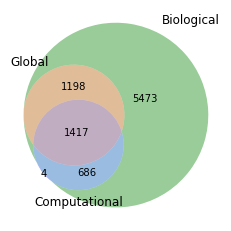

In [18]:
venn.venn3([set(glob_proteins.columns), set(bio_proteins.columns), set(cpu_proteins)], ("Global", "Biological", "Computational"))

In [38]:
meta[bio_proteins.O75970.notna()]

,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession,all_PSM,sign_PSM,peptides,proteins,experiment_type,instrument,pmid,pool_id,ionbot_version,Group
assay_id,,,,,,,,,,,,,,,,,,,,
30960,1815,3B10-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,NaN,PXD000533,11014,10578,9705,2401,in-solution,Q-exactive,24328083,1,IONBOT_v0.8.0,HCC
30961,1815,3B10-2,545,Hep3B,hepatocellular carcinoma,/,liver,/,NaN,PXD000533,11530,11036,10104,2449,in-solution,Q-exactive,24328083,2,IONBOT_v0.8.0,HCC
31336,1825,ZR_con_1d_130618_cyt2,557,ZR751,ductal carcinoma,/,breast,/,NaN,PXD001327,27761,25868,23191,1859,in-gel,Q-exactive,25238572,1,IONBOT_v0.8.0,Ductal_breast
31339,1825,ZR_con_1d_130618_cyt2b,557,ZR751,ductal carcinoma,/,breast,/,NaN,PXD001327,28333,26579,23824,1891,in-gel,Q-exactive,25238572,2,IONBOT_v0.8.0,Ductal_breast
31353,1827,20140127_EXQ4_JRW_D52_1_L,551,MCF7,adenocarcinoma,/,breast,/,NaN,PXD001352,57119,53559,47775,4903,FASP,Q-exactive,25475432,0,IONBOT_v0.8.0,Ductal_breast
31354,1827,20140127_EXQ4_JRW_D52_1_T,551,MCF7,adenocarcinoma,/,breast,/,NaN,PXD001352,55718,49619,43721,5586,FASP,Q-exactive,25475432,0,IONBOT_v0.8.0,Ductal_breast
31355,1827,20140127_EXQ4_JRW_D52_2_L,551,MCF7,adenocarcinoma,/,breast,/,NaN,PXD001352,57190,53611,47886,4891,FASP,Q-exactive,25475432,0,IONBOT_v0.8.0,Ductal_breast
31356,1827,20140127_EXQ4_JRW_D52_2_T,551,MCF7,adenocarcinoma,/,breast,/,NaN,PXD001352,58739,51984,46037,5669,FASP,Q-exactive,25475432,0,IONBOT_v0.8.0,Ductal_breast
31360,1828,20121023_EXQ4_JRW_SA_31L_1,565,U87,glioblastoma,/,brain,/,NaN,PXD000661,53996,49583,45246,5041,FASP,Q-exactive,25225357,0,IONBOT_v0.8.0,glioblastoma


In [40]:
data_cpu_filter.columns

Int64Index([    7,    65,    68,   105,   155,   218,   221,   224,   225,
              226,
            ...
            14427, 14428, 14440, 14441, 14455, 14466, 14485, 14489, 14490,
            14497],
           dtype='int64', length=1857)

In [43]:
data.iloc[:,data_cpu_filter.columns].columns

Index(['A0A096LP55', 'A0MZ66', 'A0PJW6', 'A2RRP1', 'A5PLN9', 'A6NHL2',
       'A6NHQ2', 'A6NHR9', 'A6NHT5', 'A6NHX0',
       ...
       'Q9Y6C9', 'Q9Y6D5', 'Q9Y6G9', 'Q9Y6H1', 'Q9Y6K5', 'Q9Y6N1', 'Q9Y6R9',
       'Q9Y6V7', 'Q9Y6W3', 'Q9Y6X5'],
      dtype='object', length=1857)

In [31]:
bio_proteins.columns[(data.loc[:, bio_proteins.columns].isna().sum().reset_index(drop=True)) > 500]

Index(['P28799', 'Q13268', 'P53801', 'O75298', 'O75970', 'Q9HB09', 'Q9BQI0'], dtype='object')

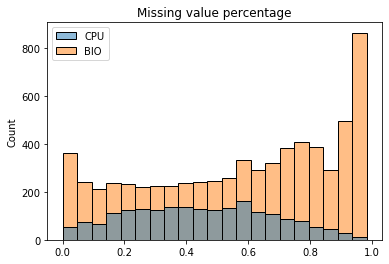

In [10]:
missing_percentage = pd.concat([data.iloc[:, data_cpu_filter.columns].isna().sum().reset_index(drop=True) / 518, data.loc[:, bio_proteins.columns].isna().sum().reset_index(drop=True) / 518], 
          axis=1, ignore_index=True)

plt.title("Missing values for selected features")
plt.title("Missing value percentage")
sns.histplot(data=missing_percentage.rename(columns={0: "CPU", 1: "BIO"}))

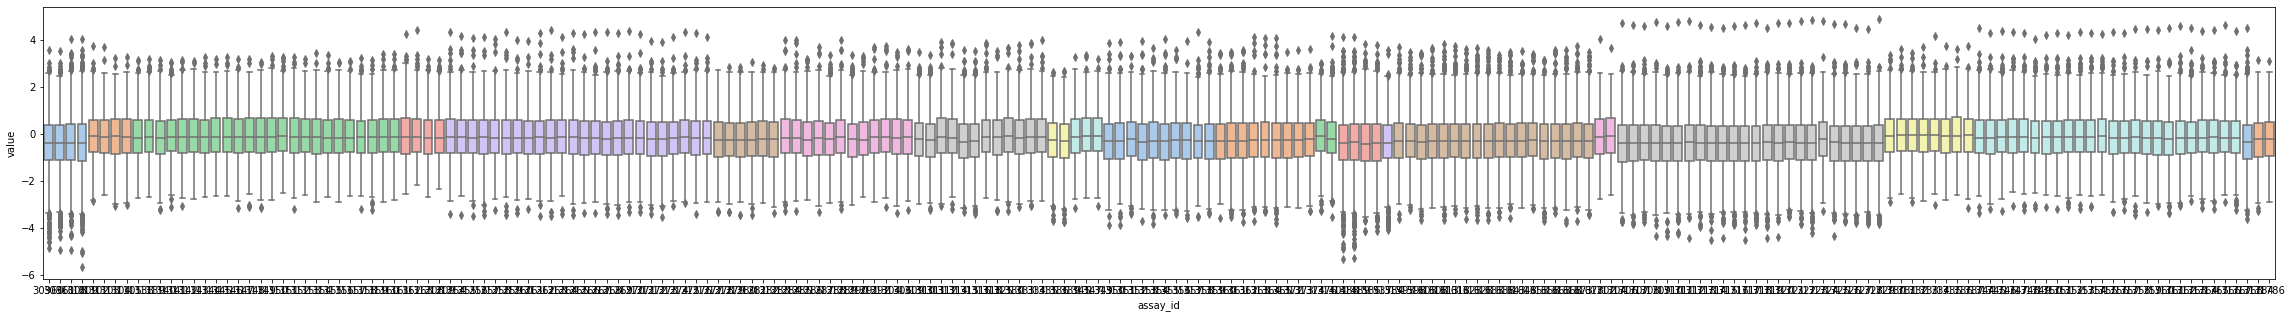

In [52]:
mapper = zip(meta.PXD_accession[:200].unique(), sns.color_palette("pastel", n_colors=meta.PXD_accession[:200].nunique()))
mapper = dict(mapper)

plt.figure(figsize=(40,5))
sns.boxplot(data=data.loc[:, glob_proteins.columns].T.melt()[data.loc[:, glob_proteins.columns].T.melt().assay_id.isin(data.loc[:, glob_proteins.columns].T.melt().assay_id.unique()[:200])], 
            y="value", x = "assay_id", palette=meta.iloc[:200,:].PXD_accession.apply(lambda x: mapper[x]).values)

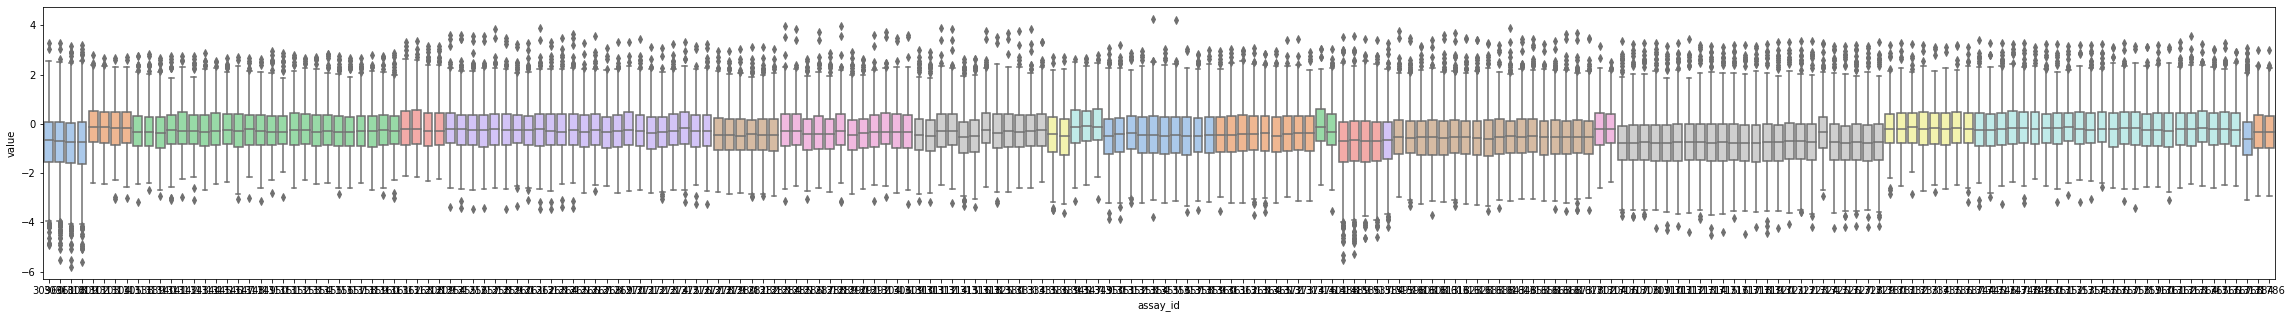

In [49]:
mapper = zip(meta.PXD_accession[:200].unique(), sns.color_palette("pastel", n_colors=meta.PXD_accession[:200].nunique()))
mapper = dict(mapper)

plt.figure(figsize=(40,5))
sns.boxplot(data=data.iloc[:, data_cpu_filter.columns].T.melt()[data.iloc[:, data_cpu_filter.columns].T.melt().assay_id.isin(data.iloc[:, data_cpu_filter.columns].T.melt().assay_id.unique()[:200])], 
            y="value", x = "assay_id", palette=meta.iloc[:200,:].PXD_accession.apply(lambda x: mapper[x]).values)

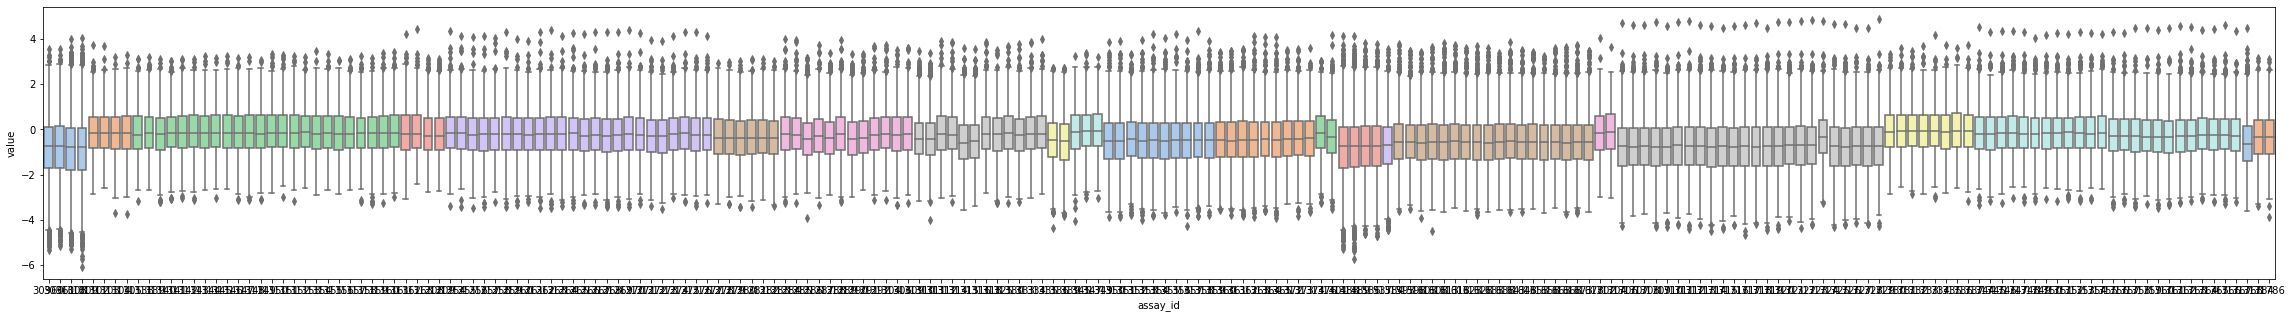

In [50]:
mapper = zip(meta.PXD_accession[:200].unique(), sns.color_palette("pastel", n_colors=meta.PXD_accession[:200].nunique()))
mapper = dict(mapper)

plt.figure(figsize=(40,5))
sns.boxplot(data=data.loc[:, bio_proteins.columns].T.melt()[data.loc[:, bio_proteins.columns].T.melt().assay_id.isin(data.loc[:, bio_proteins.columns].T.melt().assay_id.unique()[:200])], 
            y="value", x = "assay_id", palette=meta.iloc[:200,:].PXD_accession.apply(lambda x: mapper[x]).values)

In [39]:
data.columns[preprocessor.named_steps.feature_selection.final_mask]

Index(['A1L020', 'A6NHL2', 'A6NKG5', 'O00115', 'O00159', 'O00291', 'O00303',
       'O00401', 'O00443', 'O00451',
       ...
       'Q9Y4G6', 'Q9Y4P8', 'Q9Y5K6', 'Q9Y5T5', 'Q9Y5Z9', 'Q9Y625', 'Q9Y6D5',
       'Q9Y6H1', 'Q9Y6W3', 'Q9Y6X5'],
      dtype='object', length=480)

## Evaluating behaviour of computational filtering methods

---

# Oversampling

Due to class imbalance, oversampling might be a good idea. SMOTETomek and SMOTEEEN combine SMOTE, which generates new examples utilizing the feature space of the real samples and generating a new datapoint between nearest neighbours of that datapoint, and TOMEK/EEN, which prunes noisy generated datapoints from SMOTE.

---

# Grid search logistic regression, RandomForest, SVC

Grid search parameter types:
- imputation method (KNN, RF imputer, LVI)
- Filter (occurence %)
- LR parameters (C, solver, penalty type)
- feature selection (no feature selection, Chi, anova, MI)

In [ ]:
# Models to be used:

# The models

lgbm_clf = lgbm()
xgb_clf = XGBClassifier()
svc_clf = SVC()
rf_clf = RandomForestClassifier()
lr_l1_clf = LogisticRegression(max_iter = 10000)
lr_l2_clf = LogisticRegression(max_iter = 10000)
gnb_clf = GaussianNB()

# Parameter grids
lr_l1_grid = {"penalty" : ['l2'],
            "dual": [False],
            "max_iter": [10000],
            "class_weight": [weights, None],
            "C": np.linspace(0.005, 15, 20),
            'solver': ['newton-cg', 'sag', 'lbfgs', "liblinear"]}

lr_l2_grid = {"penalty" : ['l1'],
            "dual": [False],
            "max_iter": [10000],
            "class_weight": [weights, None],
            "C": np.linspace(0.005, 15, 20),
            'solver': ["liblinear"]}

svc_grid = {'decision_function_shape': ["ovr"],
            "kernel": ['linear', 'poly', 'rbf'],
            "C": np.linspace(0.0005, 10, 20),
            "class_weight": [weights,None]}

rf_grid = {'n_estimators': np.linspace(10, 200, 4, dtype = int),
            "criterion": ["entropy", "gini"], 
            "max_depth": [5,10,15,20,40, None],
            "class_weight": [weights,None]}

gnb_grid = {'var_smoothing': np.logspace(0,-15,20)}

xgb_grid = {"verbosity": [0],
            'eta': np.linspace(0.005,0.5,5),
            'gamma': np.linspace(0.005,10,5),
            'max_depth': [3,5,7,10]}

model_grids = {"lr1": (lr_l1_clf ,lr_l1_grid), "lr2":(lr_l2_clf, lr_l2_grid), 
               "svc": (svc_clf, svc_grid), "rf": (rf_clf, rf_grid), "gnb": (gnb_clf, gnb_grid)}

# Compare feature importances for the workflows (biological vs computational filtering)

In [24]:
splitter = uml.ProjectBasedSplit(10, meta, on = "Group")

for x, y in splitter.split(data, meta):
    print(meta.iloc[x,:].Group.nunique(), meta.iloc[y,:].Group.nunique())

15 7
15 5
15 8
15 8
15 8
15 5
15 5
15 7
15 9
15 8
